In [1]:
import os
import random
import shutil

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torchvision.transforms import RandAugment
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import PIL.Image as Image

In [2]:
# Print PyTorch version
print("PyTorch version:", torch.__version__)

# Check if GPU is available and get the GPU device name
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU device found: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU found. Please ensure your GPU is installed correctly and CUDA/cuDNN are set up properly.")

PyTorch version: 2.5.1+cu124
GPU device found: NVIDIA GeForce GTX 1080 Ti


## Data Augmentation

In [3]:
# Define the base directory where all images are stored
BASE_DIR = '/home/bioinfo01/Desktop/BIMB PAK RICO/2117051075_Adli Fiqrullah/dataset_nonAugment'
AUG_DIR = '/home/bioinfo01/Desktop/BIMB PAK RICO/2117051075_Adli Fiqrullah/dataset_augment'

train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'validation')
test_dir = os.path.join(BASE_DIR, 'test')

aug_train_dir = os.path.join(AUG_DIR, 'train')
aug_val_dir = os.path.join(AUG_DIR, 'validation')
aug_test_dir = os.path.join(AUG_DIR, 'test')

In [4]:
IMG_SIZE = (224, 224)

# Create directories if not exist
os.makedirs(aug_train_dir, exist_ok=True)
os.makedirs(aug_val_dir, exist_ok=True)
os.makedirs(aug_test_dir, exist_ok=True)

In [5]:
# Define data augmentation transforms
rand_augment = RandAugment()
random_erasing = transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3))
basic_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    rand_augment,
    transforms.ToTensor(),
    random_erasing
])

def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    '''Returns cutmixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]

    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def rand_bbox(size, lam):
    '''Generate random bounding box'''
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [6]:
def copy_and_augment_data(src_dir, dest_dir, img_size, basic_transforms):
    class_names = os.listdir(src_dir)

    for class_name in class_names:
        class_src_dir = os.path.join(src_dir, class_name)
        class_dest_dir = os.path.join(dest_dir, class_name)
        os.makedirs(class_dest_dir, exist_ok=True)

        for file in tqdm(os.listdir(class_src_dir), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_src_dir, file)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.webp')):
                image = cv2.imread(img_path)
                if image is not None:
                    # Copy original file to destination
                    shutil.copy(img_path, class_dest_dir)

                    # Step 1: Apply Random Erasing (via basic_transforms)
                    transformed_image = basic_transforms(image)
                    tensor_image = transformed_image.unsqueeze(0).cuda()  # Convert to tensor and move to GPU
                    
                    # Create dummy target for class index (replace with actual label if available)
                    target = torch.tensor([0]).cuda()

                    # Step 2: Apply Mixup
                    mixed_image, _, _, _ = mixup_data(tensor_image, target)
                    
                    # Step 3: Apply CutMix on the Mixup result
                    cutmix_image, _, _, _ = cutmix_data(mixed_image, target)

                    # Convert the final augmented image back to NumPy array for saving
                    final_augmented_image = cutmix_image.squeeze().permute(1, 2, 0).cpu().numpy() * 255
                    final_augmented_image = final_augmented_image.astype(np.uint8)

                    # Save the final augmented image
                    augmented_img_path = os.path.join(class_dest_dir, f'augmented_{file}')
                    cv2.imwrite(augmented_img_path, final_augmented_image)

In [7]:
# Call the function for train, validation, and test directories
copy_and_augment_data(train_dir, aug_train_dir, IMG_SIZE, basic_transforms)
copy_and_augment_data(val_dir, aug_val_dir, IMG_SIZE, basic_transforms)
copy_and_augment_data(test_dir, aug_test_dir, IMG_SIZE, basic_transforms)

print("Data augmentation completed.")

Processing kupu_jarak: 100%|███████████████████| 20/20 [00:00<00:00, 116.86it/s]

Data augmentation completed.


## Load Dataset

In [8]:
# Define the base directory where all images are stored
BASE_DIR = '/home/bioinfo01/Desktop/BIMB PAK RICO/2117051075_Adli Fiqrullah/dataset_augment'
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'validation')
test_dir = os.path.join(BASE_DIR, 'test')

class_names = os.listdir(train_dir)

class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

In [9]:
def load_data(directory):
    images = []
    labels = []

    for folder in os.listdir(directory):
        if folder in class_names:
            label = class_names.index(folder)

            folder_path = os.path.join(directory, folder)
            for file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, file)

                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.webp')):
                    image = cv2.imread(img_path)

                    if image is not None:
                        # Resize the image to IMG_SIZE
                        resized_image = cv2.resize(image, IMG_SIZE)

                        images.append(resized_image)
                        labels.append(label)

    images = np.array(images, dtype="float32")
    labels = np.array(labels, dtype="int32")

    # Shuffle the data using sklearn.utils.shuffle
    images, labels = shuffle(images, labels, random_state=25)

    return images, labels

In [10]:
train_images, train_labels = load_data(train_dir)
val_images, val_labels = load_data(val_dir)
test_images, test_labels = load_data(test_dir)

train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [11]:
def count_images_and_classes(data_dir):
    dataset = datasets.ImageFolder(data_dir)
    num_images = len(dataset)
    num_classes = len(dataset.classes)
    return num_images, num_classes

# Hitung jumlah gambar dan kelas dalam dataset
num_train_images, num_train_classes = count_images_and_classes(train_dir)
num_val_images, num_val_classes = count_images_and_classes(val_dir)
num_test_images, num_test_classes = count_images_and_classes(test_dir)

print(f"Found {num_train_images} training data images having {num_train_classes} classes.")
print(f"Found {num_val_images} validation data images having {num_val_classes} classes.")
print(f"Found {num_test_images} testing data images having {num_test_classes} classes.")

Found 1120 training data images having 8 classes.
Found 160 validation data images having 8 classes.
Found 320 testing data images having 8 classes.


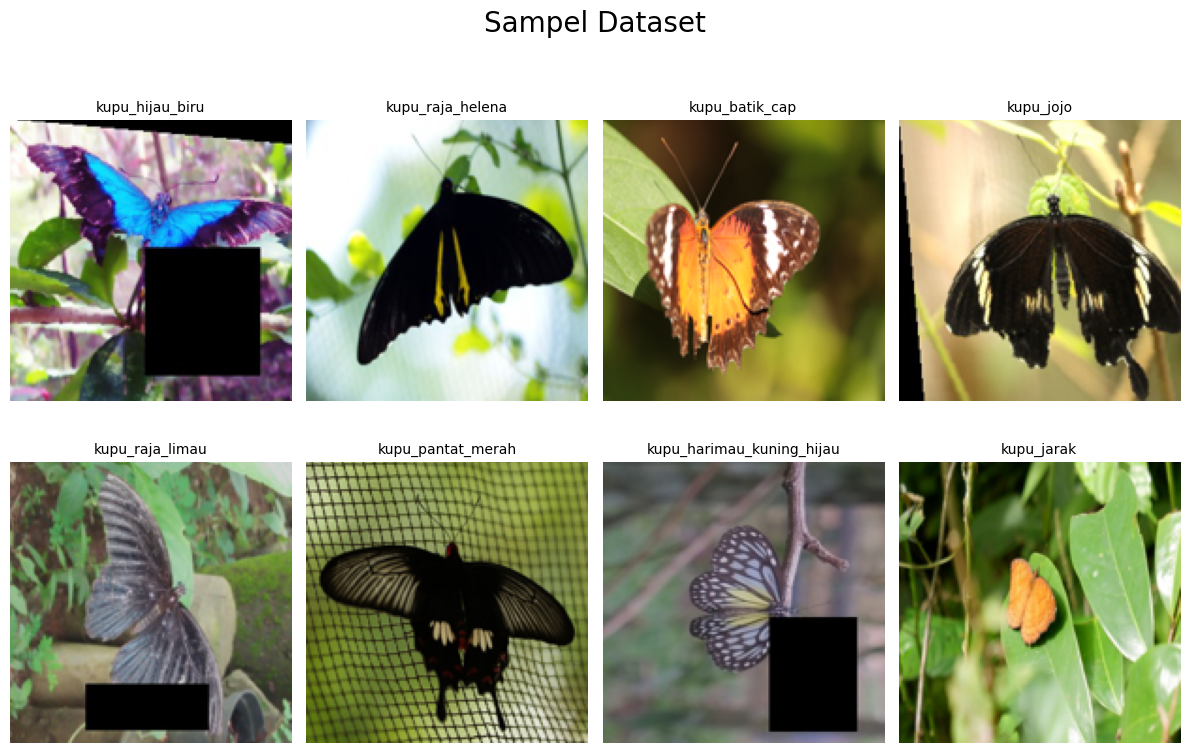

In [12]:
dataset_folder = '/home/bioinfo01/Desktop/BIMB PAK RICO/2117051075_Adli Fiqrullah/dataset_augment/train'

# Mendapatkan daftar subfolder
subfolders = [f for f in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, f))]

# Membuat grid
num_images = len(subfolders)
images_per_row = 4
num_rows = (num_images + images_per_row - 1) // images_per_row  # Hitung jumlah baris

# Ukuran grid
fig, axes = plt.subplots(nrows=num_rows, ncols=images_per_row, figsize=(12, num_rows * 4))
axes = axes.flatten()

# Ukuran gambar
image_size = (150, 150)  # (lebar, tinggi)
plt.suptitle("Sampel Dataset", fontsize=20, y=1)

# Loop melalui subfolder dan menampilkan gambar pertama dari setiap subfolder
for i, subfolder in enumerate(subfolders):
    subfolder_path = os.path.join(dataset_folder, subfolder)
    images = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if images:
        # Baca gambar pertama dari subfolder
        img_path = os.path.join(subfolder_path, images[0])
        img = Image.open(img_path)
        
        # Resize gambar agar semua memiliki ukuran yang sama
        img = img.resize(image_size)
        
        # Tampilkan gambar
        axes[i].imshow(img)
        axes[i].set_title(subfolder, fontsize=10)  # Menampilkan nama subfolder sebagai label
        axes[i].axis('off')  # Matikan sumbu

# Menghapus sisa axes jika lebih banyak grid daripada gambar
for ax in axes[num_images:]:
    ax.axis('off')

plt.tight_layout()  # Atur tata letak agar lebih rapi
plt.show()

## Preprocessing

In [13]:
# Define data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [14]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get class names and number of classes
class_names = train_dataset.classes
nb_classes = len(class_names)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Training

In [15]:
wideresnet_model = models.wide_resnet50_2(pretrained=True)
wideresnet_model.fc = nn.Linear(wideresnet_model.fc.in_features, nb_classes)
wideresnet_model = wideresnet_model.to(device)

/home/bioinfo01/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bioinfo01/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
googlenet_model = models.googlenet(pretrained=True)
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, nb_classes)
googlenet_model = googlenet_model.to(device)

/home/bioinfo01/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
alexnet_model = models.alexnet(pretrained=True)
alexnet_model.classifier[6] = nn.Linear(alexnet_model.classifier[6].in_features, nb_classes)
alexnet_model = alexnet_model.to(device)

/home/bioinfo01/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [19]:
criterion = nn.CrossEntropyLoss()

optimizer_wideresnet = optim.Adam(wideresnet_model.parameters(), lr=0.001)
optimizer_googlenet = optim.Adam(googlenet_model.parameters(), lr=0.001)
optimizer_alexnet = optim.Adam(alexnet_model.parameters(), lr=0.001)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

In [20]:
wideresnet_model, history_wideresnet = train_model(wideresnet_model, dataloaders, criterion, optimizer_wideresnet, num_epochs=20)

Epoch 1/20
----------
train Loss: 1.1543 Acc: 0.6482
val Loss: 1.4627 Acc: 0.4938

Epoch 2/20
----------
train Loss: 0.7536 Acc: 0.7643
val Loss: 2.0182 Acc: 0.4875

Epoch 3/20
----------
train Loss: 0.6284 Acc: 0.8009
val Loss: 0.4072 Acc: 0.8563

Epoch 4/20
----------
train Loss: 0.5578 Acc: 0.8339
val Loss: 0.9974 Acc: 0.6813

Epoch 5/20
----------
train Loss: 0.4997 Acc: 0.8589
val Loss: 0.8955 Acc: 0.7875

Epoch 6/20
----------
train Loss: 0.5089 Acc: 0.8402
val Loss: 0.4054 Acc: 0.8563

Epoch 7/20
----------
train Loss: 0.3579 Acc: 0.8884
val Loss: 0.4650 Acc: 0.8688

Epoch 8/20
----------
train Loss: 0.3812 Acc: 0.8812
val Loss: 0.7352 Acc: 0.7625

Epoch 9/20
----------
train Loss: 0.2935 Acc: 0.9089
val Loss: 0.2464 Acc: 0.9250

Epoch 10/20
----------
train Loss: 0.3199 Acc: 0.8991
val Loss: 0.1471 Acc: 0.9438

Epoch 11/20
----------
train Loss: 0.2622 Acc: 0.9268
val Loss: 0.4477 Acc: 0.8438

Epoch 12/20
----------
train Loss: 0.2587 Acc: 0.9161
val Loss: 0.3033 Acc: 0.9062

E

In [21]:
googlenet_model, history_googlenet = train_model(googlenet_model, dataloaders, criterion, optimizer_googlenet, num_epochs=20)

Epoch 1/20
----------
train Loss: 0.4998 Acc: 0.8509
val Loss: 0.3627 Acc: 0.8875

Epoch 2/20
----------
train Loss: 0.2508 Acc: 0.9241
val Loss: 0.2541 Acc: 0.9438

Epoch 3/20
----------
train Loss: 0.2285 Acc: 0.9277
val Loss: 0.1615 Acc: 0.9313

Epoch 4/20
----------
train Loss: 0.2231 Acc: 0.9348
val Loss: 0.3260 Acc: 0.9000

Epoch 5/20
----------
train Loss: 0.1788 Acc: 0.9429
val Loss: 0.1152 Acc: 0.9625

Epoch 6/20
----------
train Loss: 0.1222 Acc: 0.9634
val Loss: 0.0631 Acc: 0.9750

Epoch 7/20
----------
train Loss: 0.1727 Acc: 0.9554
val Loss: 0.0654 Acc: 0.9938

Epoch 8/20
----------
train Loss: 0.1818 Acc: 0.9420
val Loss: 0.1548 Acc: 0.9563

Epoch 9/20
----------
train Loss: 0.1604 Acc: 0.9536
val Loss: 0.1680 Acc: 0.9375

Epoch 10/20
----------
train Loss: 0.1644 Acc: 0.9527
val Loss: 0.2870 Acc: 0.9313

Epoch 11/20
----------
train Loss: 0.1056 Acc: 0.9705
val Loss: 0.2272 Acc: 0.9250

Epoch 12/20
----------
train Loss: 0.1354 Acc: 0.9580
val Loss: 0.2565 Acc: 0.9188

E

In [22]:
alexnet_model, history_alexnet = train_model(alexnet_model, dataloaders, criterion, optimizer_alexnet, num_epochs=20)

Epoch 1/20
----------
train Loss: 2.1116 Acc: 0.2446
val Loss: 1.9984 Acc: 0.1813

Epoch 2/20
----------
train Loss: 2.1050 Acc: 0.1527
val Loss: 2.0836 Acc: 0.1250

Epoch 3/20
----------
train Loss: 2.0871 Acc: 0.1116
val Loss: 2.0801 Acc: 0.1250

Epoch 4/20
----------
train Loss: 2.0843 Acc: 0.1250
val Loss: 2.0801 Acc: 0.1250

Epoch 5/20
----------
train Loss: 2.0819 Acc: 0.1170
val Loss: 2.0797 Acc: 0.1250

Epoch 6/20
----------
train Loss: 2.0830 Acc: 0.1259
val Loss: 2.0799 Acc: 0.1250

Epoch 7/20
----------
train Loss: 2.0813 Acc: 0.1250
val Loss: 2.0796 Acc: 0.1250

Epoch 8/20
----------
train Loss: 2.0810 Acc: 0.1250
val Loss: 2.0795 Acc: 0.1250

Epoch 9/20
----------
train Loss: 2.0812 Acc: 0.1179
val Loss: 2.0796 Acc: 0.1250

Epoch 10/20
----------
train Loss: 2.0810 Acc: 0.1179
val Loss: 2.0796 Acc: 0.1250

Epoch 11/20
----------
train Loss: 2.0808 Acc: 0.1116
val Loss: 2.0796 Acc: 0.1250

Epoch 12/20
----------
train Loss: 2.0813 Acc: 0.1107
val Loss: 2.0795 Acc: 0.1250

E

In [23]:
# Save the models
torch.save(wideresnet_model.state_dict(), '/home/bioinfo01/Desktop/BIMB PAK RICO/2117051075_Adli Fiqrullah/wideresnet_model.pth')
torch.save(googlenet_model.state_dict(), '/home/bioinfo01/Desktop/BIMB PAK RICO/2117051075_Adli Fiqrullah/googlenet_model.pth')
torch.save(alexnet_model.state_dict(), '/home/bioinfo01/Desktop/BIMB PAK RICO/2117051075_Adli Fiqrullah/alexnet_model.pth')

## Testing

In [24]:
# Function to load and preprocess image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = data_transforms['test'](image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image.to(device)

# Function to make predictions
def predict_image(model, image_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)
    return preds.item()

# Function to display image and prediction
def display_predictions(images_paths, predictions, class_names, model_names, accuracies, species_accuracies):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        image = Image.open(images_paths[i])
        ax.imshow(image)
        pred_text = (f"{class_names[i]}\n"
                     f"{model_names[0]}: {class_names[predictions[i][0]]}\n"
                     f"{model_names[1]}: {class_names[predictions[i][1]]}\n"
                     f"{model_names[2]}: {class_names[predictions[i][2]]}\n"
                     f"Acc {model_names[0]}: {species_accuracies[0][i]:.2f}, {model_names[1]}: {species_accuracies[1][i]:.2f}, {model_names[2]}: {species_accuracies[2][i]:.2f}")
        ax.text(260, 20, pred_text, fontsize=8, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8), linespacing=1)
        ax.axis('off')
    fig.suptitle(f"Overall Accuracies: WRN: {accuracies[0]:.2f}, GN: {accuracies[1]:.2f}, AN: {accuracies[2]:.2f}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [25]:
# Define the paths to sample images from each class
sample_images_paths = []
for class_name in class_names:
    class_folder = os.path.join(test_dir, class_name)
    sample_image = os.path.join(class_folder, os.listdir(class_folder)[0])
    sample_images_paths.append(sample_image)

# Load and preprocess the images
images_tensors = [load_image(image_path) for image_path in sample_images_paths]

# Make predictions using the three models
wideresnet_predictions = [predict_image(wideresnet_model, img_tensor) for img_tensor in images_tensors]
googlenet_predictions = [predict_image(googlenet_model, img_tensor) for img_tensor in images_tensors]
alexnet_predictions = [predict_image(alexnet_model, img_tensor) for img_tensor in images_tensors]

# Combine predictions for display
predictions = list(zip(wideresnet_predictions, googlenet_predictions, alexnet_predictions))

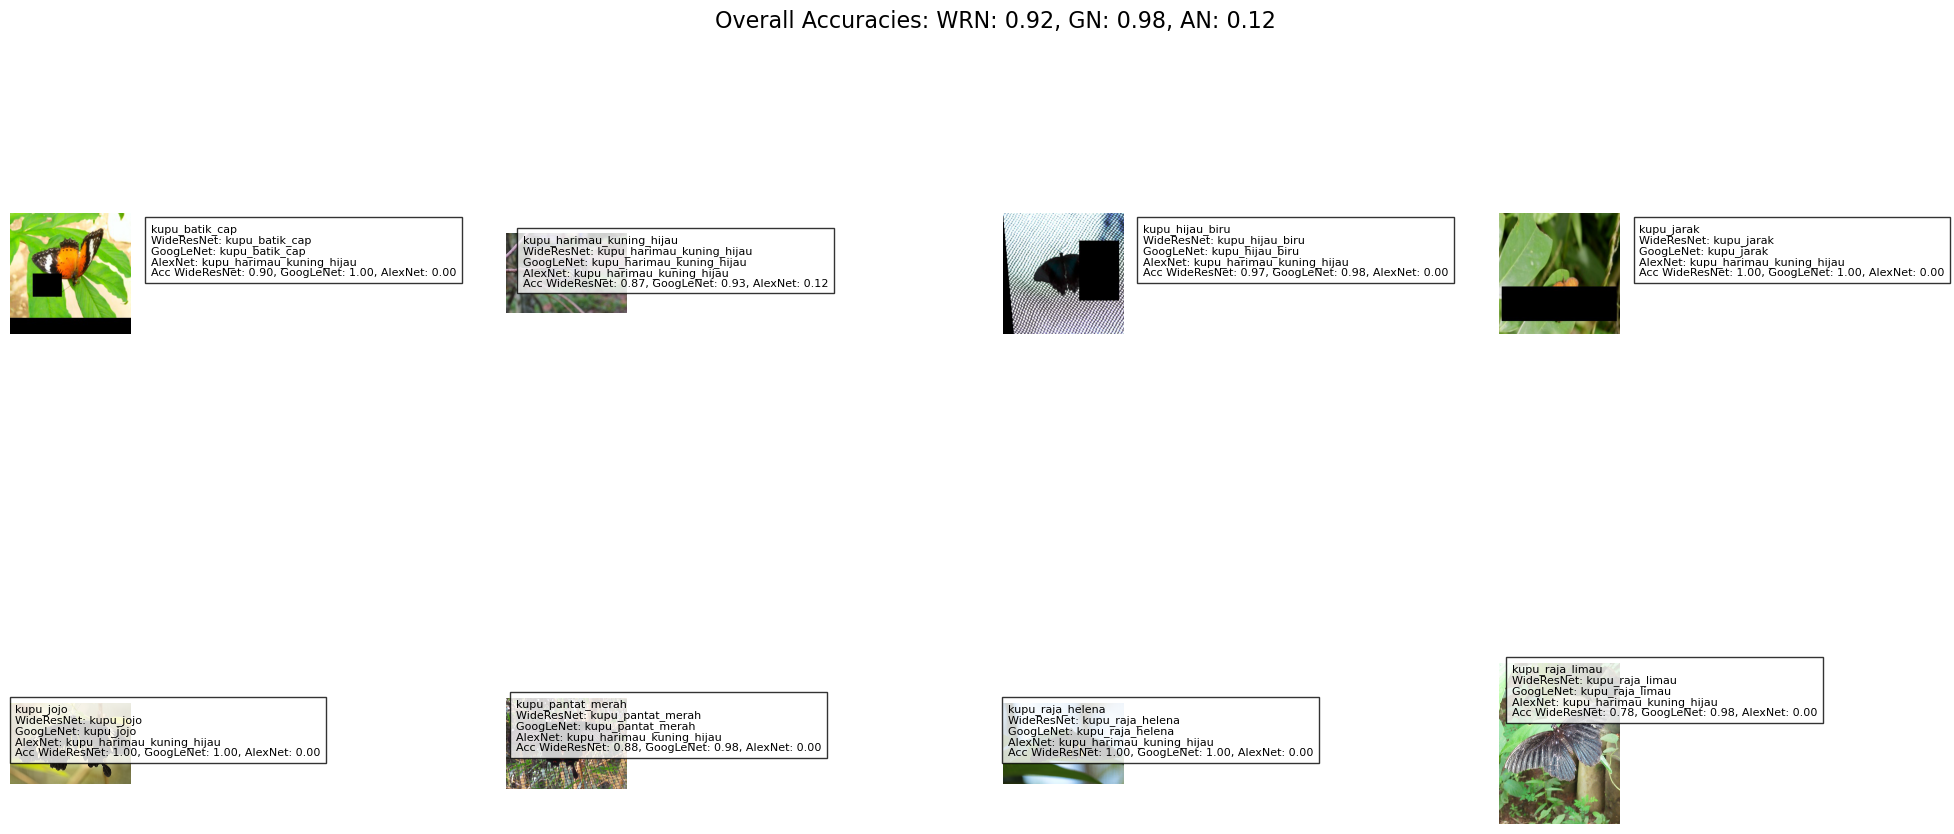

In [26]:
# Calculate accuracies for each model on the entire test set
def calculate_accuracy(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, zero_division=0)
    return accuracy, report

# Create DataLoader for test set
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Calculate accuracies
wideresnet_accuracy, wideresnet_report = calculate_accuracy(wideresnet_model, test_loader)
googlenet_accuracy, googlenet_report = calculate_accuracy(googlenet_model, test_loader)
alexnet_accuracy, alexnet_report = calculate_accuracy(alexnet_model, test_loader)

accuracies = [wideresnet_accuracy, googlenet_accuracy, alexnet_accuracy]

# Extract accuracies per species
wideresnet_species_accuracies = [wideresnet_report[class_name]['precision'] for class_name in class_names]
googlenet_species_accuracies = [googlenet_report[class_name]['precision'] for class_name in class_names]
alexnet_species_accuracies = [alexnet_report[class_name]['precision'] for class_name in class_names]

species_accuracies = [wideresnet_species_accuracies, googlenet_species_accuracies, alexnet_species_accuracies]

# Model names
model_names = ['WideResNet', 'GoogLeNet', 'AlexNet']

# Display the images and predictions
display_predictions(sample_images_paths, predictions, class_names, model_names, accuracies, species_accuracies)

## Evaluation

In [27]:
# Function to plot the accuracy and loss curves
def plot_accuracy_loss(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history['train_acc'], label='Train Accuracy')
    axes[0].plot(history['val_acc'], label='Validation Accuracy')
    axes[0].set_title(f'{model_name} Training & Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(history['train_loss'], label='Train Loss')
    axes[1].plot(history['val_loss'], label='Validation Loss')
    axes[1].set_title(f'{model_name} Training & Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

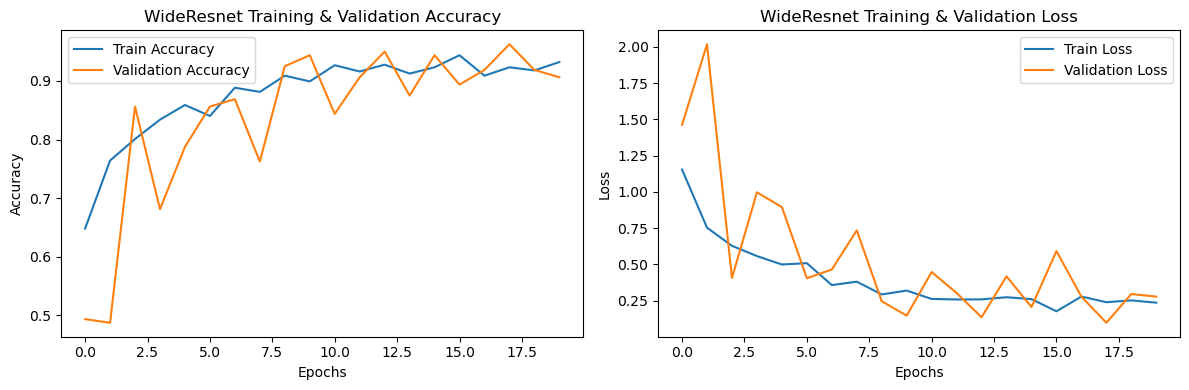

In [28]:
plot_accuracy_loss(history_wideresnet, 'WideResnet')

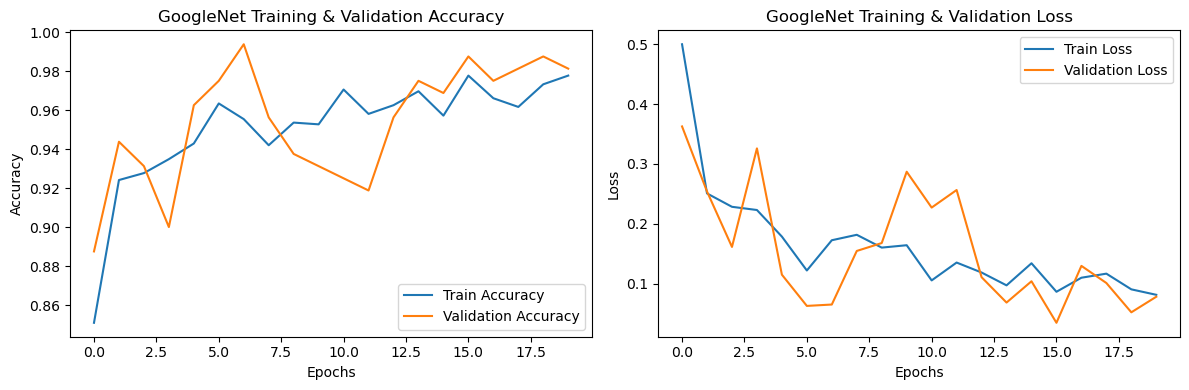

In [29]:
plot_accuracy_loss(history_googlenet, 'GoogleNet')

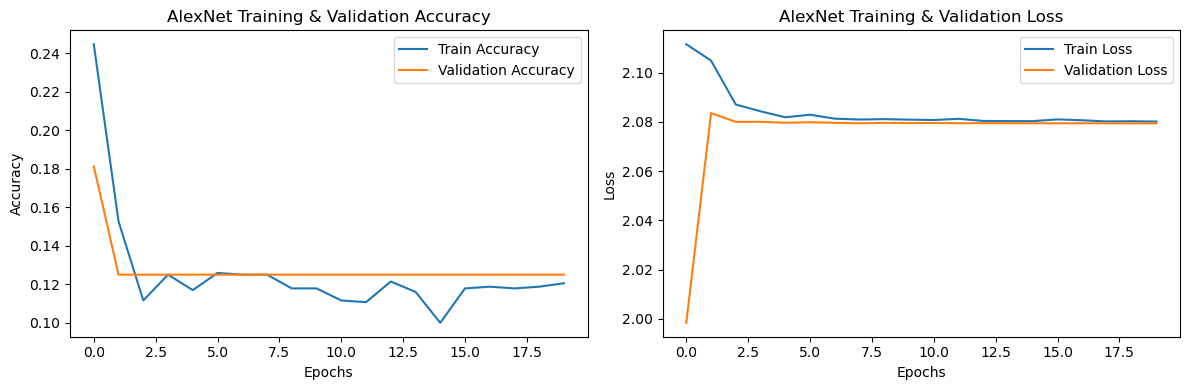

In [30]:
plot_accuracy_loss(history_alexnet, 'AlexNet')

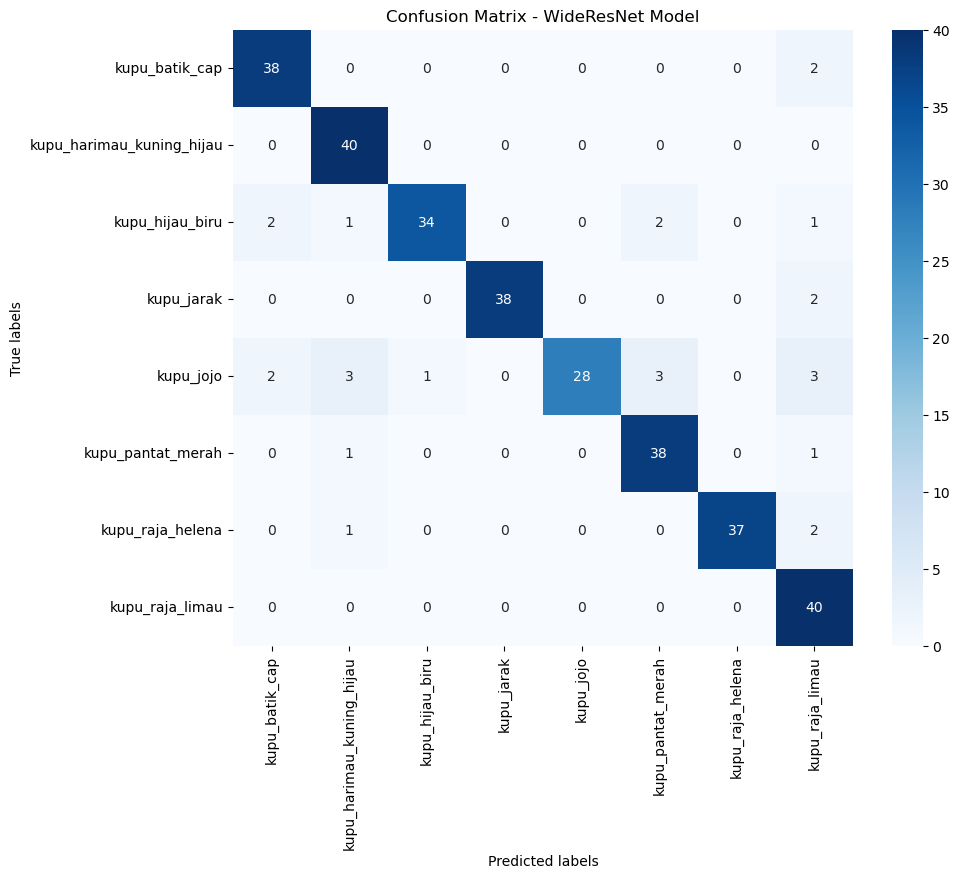

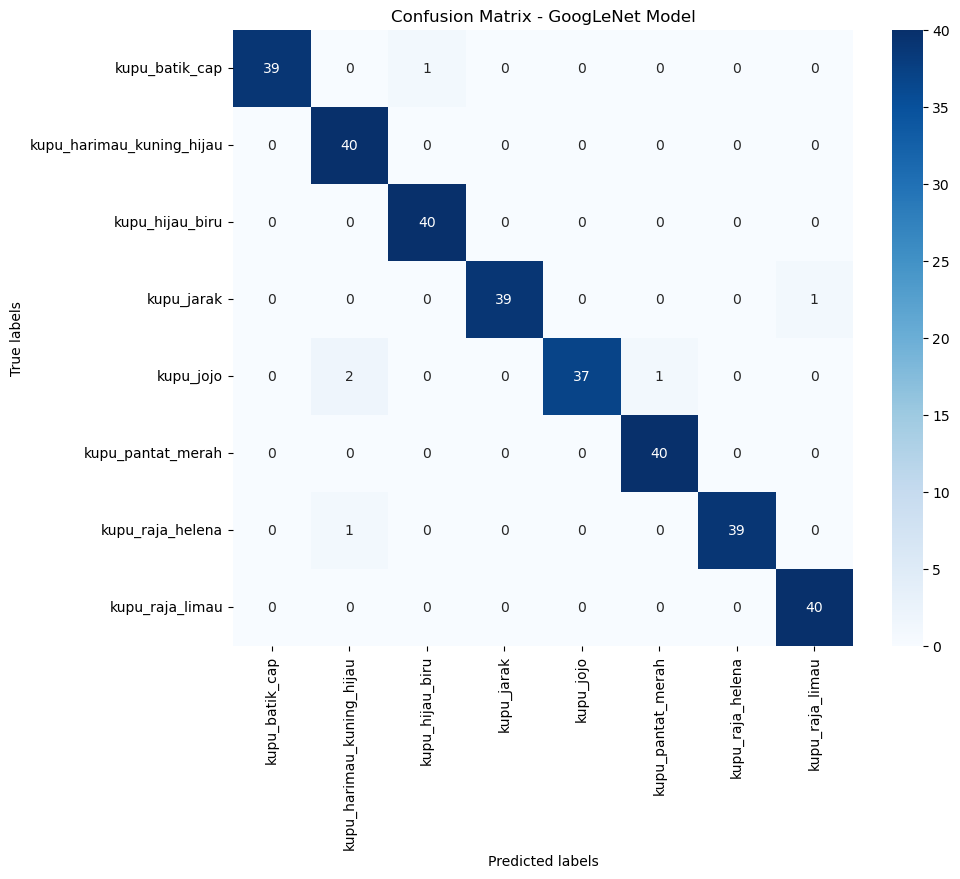

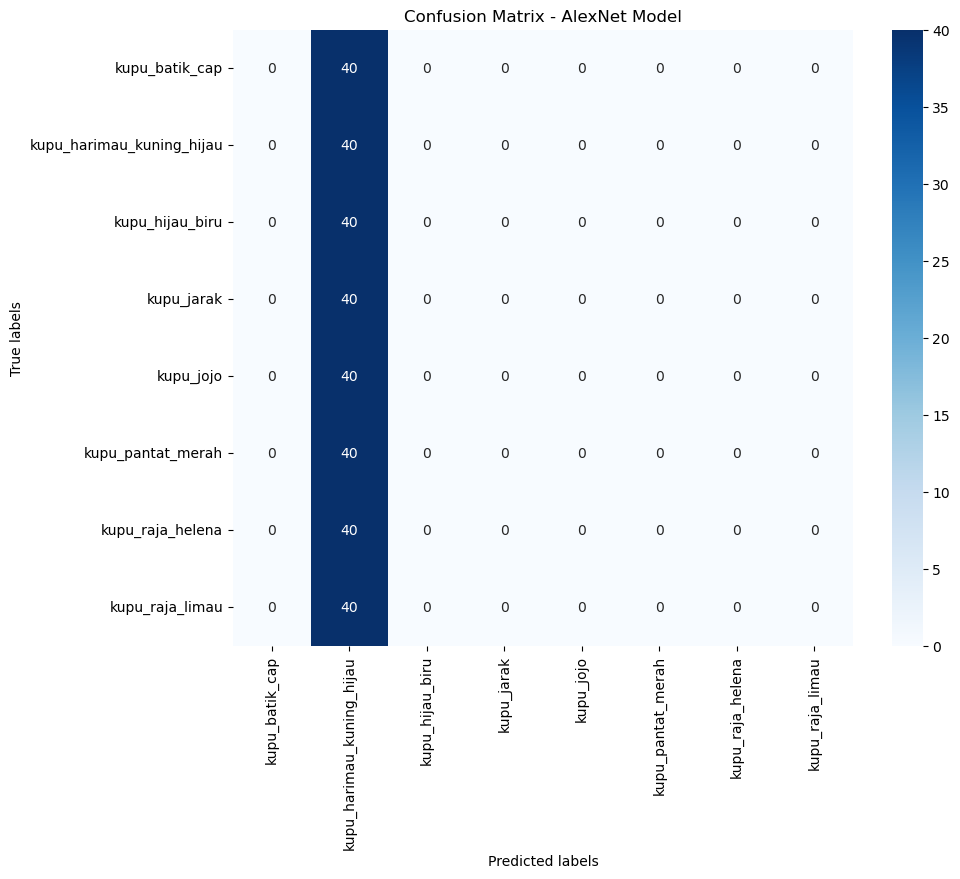

In [31]:
def evaluate_model(model, dataloaders):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_labels, all_preds

# Evaluate models
dataloaders['test'] = test_loader

wideresnet_labels, wideresnet_preds = evaluate_model(wideresnet_model, dataloaders)
googlenet_labels, googlenet_preds = evaluate_model(googlenet_model, dataloaders)
alexnet_labels, alexnet_preds = evaluate_model(alexnet_model, dataloaders)

def plot_confusion_matrix(true_labels, predicted_labels, class_names, title):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(wideresnet_labels, wideresnet_preds, class_names, 'Confusion Matrix - WideResNet Model')
plot_confusion_matrix(googlenet_labels, googlenet_preds, class_names, 'Confusion Matrix - GoogLeNet Model')
plot_confusion_matrix(alexnet_labels, alexnet_preds, class_names, 'Confusion Matrix - AlexNet Model')

In [32]:
def calculate_metrics(conf_matrix):
    with np.errstate(divide='ignore', invalid='ignore'):
        precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
        precision[np.isnan(precision)] = 0

        recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
        recall[np.isnan(recall)] = 0

        f1_score = 2 * (precision * recall) / (precision + recall)
        f1_score[np.isnan(f1_score)] = 0

    return precision, recall, f1_score

# Calculate metrics
wideresnet_conf_matrix = confusion_matrix(wideresnet_labels, wideresnet_preds)
googlenet_conf_matrix = confusion_matrix(googlenet_labels, googlenet_preds)
alexnet_conf_matrix = confusion_matrix(alexnet_labels, alexnet_preds)

wideresnet_precision, wideresnet_recall, wideresnet_f1_score = calculate_metrics(wideresnet_conf_matrix)
googlenet_precision, googlenet_recall, googlenet_f1_score = calculate_metrics(googlenet_conf_matrix)
alexnet_precision, alexnet_recall, alexnet_f1_score = calculate_metrics(alexnet_conf_matrix)

metrics_df = pd.DataFrame({
    'class_name': class_names,
    'WideResNet_precision': wideresnet_precision,
    'WideResNet_recall': wideresnet_recall,
    'WideResNet_F1_score': wideresnet_f1_score,
    'GoogLeNet_precision': googlenet_precision,
    'GoogLeNet_recall': googlenet_recall,
    'GoogLeNet_F1_score': googlenet_f1_score,
    'AlexNet_precision': alexnet_precision,
    'AlexNet_recall': alexnet_recall,
    'AlexNet_F1_score': alexnet_f1_score
})
metrics_df

,class_name,WideResNet_precision,WideResNet_recall,WideResNet_F1_score,GoogLeNet_precision,GoogLeNet_recall,GoogLeNet_F1_score,AlexNet_precision,AlexNet_recall,AlexNet_F1_score
0,kupu_batik_cap,0.904762,0.950,0.926829,1.000000,0.975,0.987342,0.000,0.0,0.000000
1,kupu_harimau_kuning_hijau,0.869565,1.000,0.930233,0.930233,1.000,0.963855,0.125,1.0,0.222222
2,kupu_hijau_biru,0.971429,0.850,0.906667,0.975610,1.000,0.987654,0.000,0.0,0.000000
3,kupu_jarak,1.000000,0.950,0.974359,1.000000,0.975,0.987342,0.000,0.0,0.000000
4,kupu_jojo,1.000000,0.700,0.823529,1.000000,0.925,0.961039,0.000,0.0,0.000000
5,kupu_pantat_merah,0.883721,0.950,0.915663,0.975610,1.000,0.987654,0.000,0.0,0.000000
6,kupu_raja_helena,1.000000,0.925,0.961039,1.000000,0.975,0.987342,0.000,0.0,0.000000
7,kupu_raja_limau,0.784314,1.000,0.879121,0.975610,1.000,0.987654,0.000,0.0,0.000000
